# Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Reading Files

In [8]:
df = pd.read_csv('Dev_data_to_be_shared.csv')

In [9]:
df_val=pd.read_csv('validation_data_to_be_shared.csv')

# Getting Overview

In [10]:
df.head()

,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,221000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,86000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,215000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96806 entries, 0 to 96805
Columns: 1216 entries, account_number to onus_attribute_48
dtypes: float64(1189), int64(27)
memory usage: 898.1 MB


(96806, 1216)

In [12]:
df.isnull().sum()

account_number                 0
bad_flag                       0
onus_attribute_1           25231
transaction_attribute_1    25231
transaction_attribute_2    25231
                           ...  
onus_attribute_44          85196
onus_attribute_45          85196
onus_attribute_46          85196
onus_attribute_47          85196
onus_attribute_48          85196
Length: 1216, dtype: int64

In [13]:
(df['bad_flag'] == 1).sum()

1372

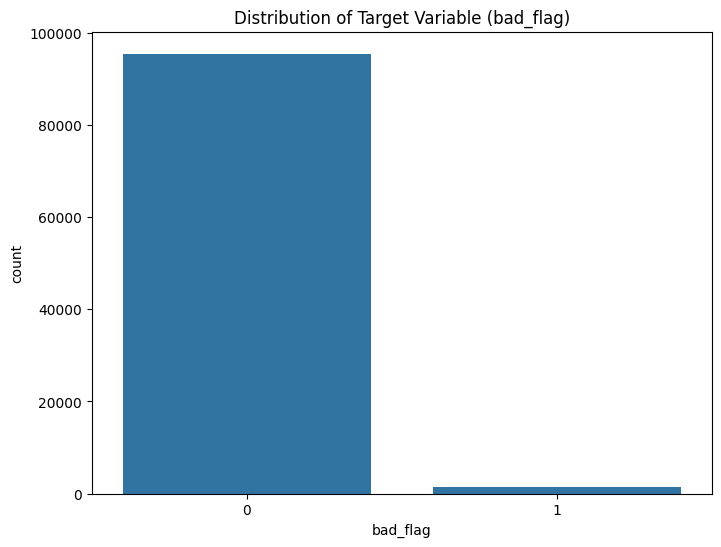


Target Variable Distribution (%):
bad_flag
0    98.6
1     1.4
Name: proportion, dtype: float64


In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='bad_flag')
plt.title('Distribution of Target Variable (bad_flag)')
plt.show()

# Print distribution percentages
print("\nTarget Variable Distribution (%):")
print(df['bad_flag'].value_counts(normalize=True).round(3) * 100)

# Handling Null Values

In [15]:
def handle_missing_values(df):
    # Calculate missing percentages
    missing_pct = (df.isnull().sum() / len(df)) * 100
    
    # Drop columns with > 70% missing values
    cols_to_drop = missing_pct[missing_pct > 70].index
    df_cleaned = df.drop(columns=cols_to_drop)
    
    # Fill remaining missing values with median (more robust than mean)
    numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
    df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].median())
    
    return df_cleaned

In [16]:
df_dev_cleaned = handle_missing_values(df)
df_val_cleaned = handle_missing_values(df_val)

In [17]:
df_dev_cleaned.shape

(96806, 1200)

In [18]:
df_val_cleaned.shape

(41792, 1199)

# Correlation Analysis

In [19]:
# # Calculate correlation with target variable only
# target_corr = df_dev_cleaned.corr()['bad_flag']
# top_features = target_corr.abs().sort_values(ascending=False)[:20].index

# # Calculate correlations only for important features
# important_corr = df_dev_cleaned[top_features].corr()

# # Plot correlation heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(important_corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap of Top 20 Features')
# plt.tight_layout()
# plt.show()

# Preparing Data

In [20]:
# Prepare features and target
X = df_dev_cleaned.drop(['bad_flag', 'account_number'], axis=1)
y = df_dev_cleaned['bad_flag']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using SMOTE

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Initialize models with balanced class weights
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(
        scale_pos_weight=96.6/3.4,  # Class weight based on distribution
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    results[name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }


Training Logistic Regression...

Training Random Forest...

Training XGBoost...


# Evaluation

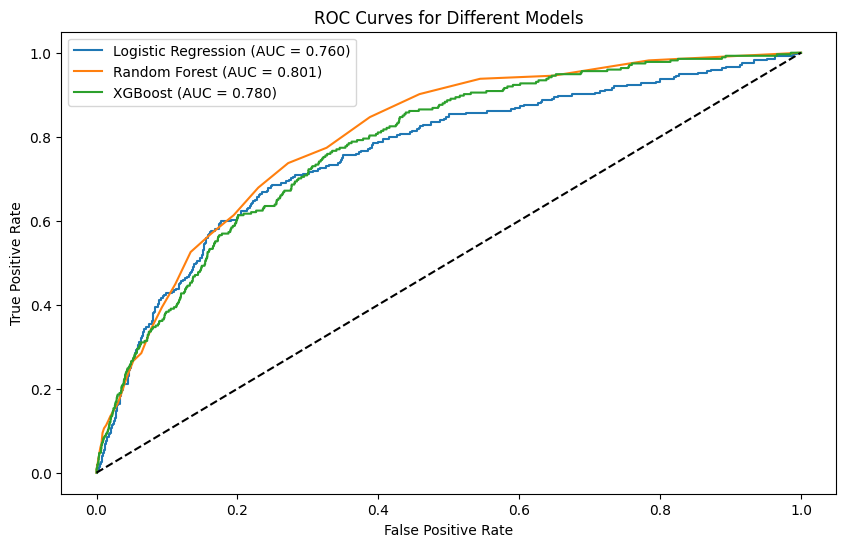


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     19088
           1       0.04      0.61      0.08       274

    accuracy                           0.79     19362
   macro avg       0.52      0.70      0.48     19362
weighted avg       0.98      0.79      0.87     19362


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19088
           1       0.33      0.00      0.01       274

    accuracy                           0.99     19362
   macro avg       0.66      0.50      0.50     19362
weighted avg       0.98      0.99      0.98     19362


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     19088
           1       0.05      0.36      0.09       274

    accuracy                           0.90     19362
   macro avg  

In [22]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

# Print classification reports
for name, result in results.items():
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, result['predictions']))